### questions 

- Currently running a exhaustive search on the scf machine 
- Whats going on with the residuals?
- How should we interpret them for what interaction terms we need and transformations or including a square of the parameter? 
- Is the time lag that we have sufficient? 

Here we are going to do new modeling for the new data set that rhiann and ashlynn completed. This is going to be making some models before we have finished running the ehxaustive search to see how it performs 

Make a baseline with the previous Spatial component and that is it!! Test it with the subsetted variables and do a training and test set to evaluate how well the model does, also compare it to this baselin that you have from just the spatial componet and that is it!! Plot the residuals also and look at it. Perhaps make code also to compute the Moran's I for the best model to see if there is a spatial componet in your model at all anymore.

In [1]:
import os 
import numpy as np
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression

/Users/meera/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/meera/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


For modeling doesn't make sense to include year in the model... because saying its a continous variable but it's not. Thus in order to include Year we should have perhaps 10 different predictor variables that are categorical indicating 0 or 1 depending on if they should be included in the model or not. 

## Loading the data and removing NA 

In [140]:
# Navigating to csv file
# os.chdir('/Users/meera/Documents/drugs/Data')
# od = pd.read_csv('od_full.csv')

# #for the modeling we have to drop the null values 
# od_nonull = od[od['Overdose_Deaths'].notna()]
# od_nonull = od_nonull.drop(['Pct_Majority_Income_to_Housing',
#                             'Pct_Child_Free_Lunch', 'Premature_Deaths',
#                             'Violent_Crime_Rate_per_100k', 'HIV_Rate_per_100k'], axis = 1)

# #now we drop all the na values 
# od_nonull = od_nonull.dropna(axis = 0)
# od_nonull.isnull().sum()

Year                         0
FIPS                         0
County                       0
State                        0
Region                       0
Division                     0
Overdose_Deaths              0
Overdose_Pop                 0
Overdose_Rate_per_100k       0
Population                   0
Pct_Age<18                   0
Pct_Age>=65                  0
Pct_Black                    0
Pct_Native                   0
Pct_Asian                    0
Pct_Pacific_Islander         0
Pct_Hispanic                 0
Pct_Not_Prof_in_Eng          0
Pct_Female                   0
Pct_Rural                    0
Pct_Diabetes                 0
Potential_Years_Lost         0
Pct_Low_Weight_Births        0
Pct_Smokers                  0
Pct_Adults_Obsese            0
Pct_Excessive_Drinking       0
Pct_DUI_Deaths               0
Teen_Birth_Rate_per_100k     0
Pct_Uninsured                0
PrimCarePhys_per_100k        0
Pct_HS_Grad                  0
Pct_College_Edu              0
Pct_Chil

In [175]:
od_nonull = pd.read_csv('od_nonull.csv')

In [3]:
#taking the log transform of this variable for the modeling !! 
#Also it should be noted that we are not going to standardize our predictors just yet !

od_y = np.log(od_nonull['Overdose_Rate_per_100k'])

In [4]:
od_x = od_nonull[['Population', 'Pct_Age<18', 'Pct_Age>=65', 'Pct_Black', 'Pct_Native',
       'Pct_Asian', 'Pct_Pacific_Islander', 'Pct_Hispanic',
       'Pct_Not_Prof_in_Eng', 'Pct_Female', 'Pct_Rural', 'Pct_Diabetes',
       'Potential_Years_Lost', 'Pct_Low_Weight_Births', 'Pct_Smokers',
       'Pct_Adults_Obsese', 'Pct_Excessive_Drinking', 'Pct_DUI_Deaths',
       'Teen_Birth_Rate_per_100k', 'Pct_Uninsured', 'PrimCarePhys_per_100k',
       'Pct_HS_Grad', 'Pct_College_Edu', 'Pct_Children_in_Poverty',
       'Pct_Child_in_1ParentHH', 'Opioid_Disp_Rate_per_100k', 'Pct_Unemployed',
       'Pct_Poverty', 'Median_HHI', 'Jail_Pop', 'Urbanicity','Prev_Spatial_Max', 'Prev_Spatial_Mean']]

In [5]:
def compute_rmse(predictions, yvalues): 
    rmse = np.sqrt(np.sum(np.subtract(yvalues, predictions)**2)/len(yvalues))
    return rmse 

## Our baseline model ! 

In [6]:
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn.metrics import r2_score 

In [7]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Prev_Spatial_Mean", 
                 data=od_nonull, return_type='dataframe')

In [8]:
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [9]:
#this is just with the spatial mean component 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = od_y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.403
Model:                                OLS   Adj. R-squared:                  0.403
Method:                     Least Squares   F-statistic:                     3798.
Date:                    Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                            13:59:29   Log-Likelihood:                -3218.9
No. Observations:                    5622   AIC:                             6442.
Df Residuals:                        5620   BIC:                             6455.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [10]:
y_test_pred = res.predict(x_test)
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.3974460152894499

In [11]:
np.array(y_test_pred)

array([2.70075559, 2.77656847, 3.48536828, ..., 2.73431703, 2.86032038,
       2.74069343])

In [12]:
y_test = np.array(y_test).reshape(1875,1)
y_test_pred = np.array(y_test_pred).reshape(1875,1)
compute_rmse(y_test, y_test_pred)

0.4447552169623239

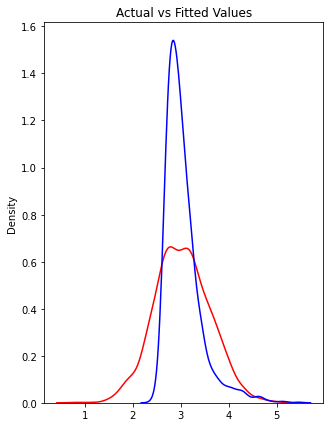

In [13]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [14]:
from sklearn import metrics 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))

Mean Absolute Error: 0.3491057417548485
Mean Squared Error: 0.1978072030152038


## Doing forward step-wise selection 

In [15]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

In [48]:
od_x.columns
od_x

,Year,Population,Pct_Age<18,Pct_Age>=65,Pct_Black,Pct_Native,Pct_Asian,Pct_Pacific_Islander,Pct_Hispanic,Pct_Not_Prof_in_Eng,...,Pct_Children_in_Poverty,Pct_Child_in_1ParentHH,Opioid_Disp_Rate_per_100k,Pct_Unemployed,Pct_Poverty,Median_HHI,Jail_Pop,Urbanicity,Prev_Spatial_Max,Prev_Spatial_Mean
1,2011,179878.0,23.100000,17.000000,10.000000,0.500000,0.600000,0.000000,3.300000,1.800000,...,15.1,28.900000,150000.0,9.0,13.4,50144.0,743.36,2.0,26.096714,16.138937
7,2011,114081.0,23.400000,15.000000,20.000000,0.400000,0.800000,0.100000,2.600000,1.500000,...,22.9,38.200000,176700.0,10.3,20.9,39060.0,504.25,2.0,17.944086,14.717519
21,2011,81778.0,23.300000,15.600000,1.700000,0.500000,0.200000,0.000000,4.400000,2.200000,...,19.7,25.600000,180600.0,9.5,18.2,39395.0,312.43,1.0,50.728854,27.746062
24,2011,69380.0,25.500000,14.300000,2.000000,0.800000,0.400000,0.100000,11.700000,5.900000,...,25.1,29.200000,100600.0,11.7,20.3,35487.0,204.54,1.0,14.544185,13.017568
26,2011,37434.0,23.000000,15.200000,32.100000,3.100000,0.300000,0.000000,1.500000,0.400000,...,31.7,41.300000,149000.0,10.7,25.5,32838.0,192.75,1.0,15.194356,12.847718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31391,2020,135693.0,21.903856,17.985452,1.243985,0.392798,1.459176,0.042744,3.220505,0.497790,...,4.9,21.036707,25100.0,5.6,5.1,81659.0,229.00,3.0,42.401287,20.457328
31392,2020,403072.0,21.508564,18.654235,1.590287,0.324012,3.886651,0.054581,4.786986,0.680531,...,4.8,18.233691,41100.0,5.6,4.2,92359.0,350.00,3.0,42.401287,22.396738
31395,2020,171020.0,20.515144,16.385218,2.170506,0.746112,3.045843,0.053210,4.200094,0.931389,...,11.6,30.599278,41000.0,5.4,8.7,64653.0,310.00,2.0,12.572169,11.874609
31396,2020,73055.0,21.556362,20.562590,0.880159,0.932174,2.003970,0.031483,3.092191,0.717323,...,13.2,28.558645,47400.0,6.7,9.4,54154.0,94.00,1.0,11.791410,11.791410


In [49]:
X_columns = od_x.columns
X = np.array(od_x).reshape(7497, 34)
y = np.array(od_y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [50]:
def compute_rmse(predictions, yvalues): 
    rmse = np.sqrt(np.sum(np.subtract(yvalues, predictions)**2)/len(yvalues))
    return rmse 

In [51]:
from sklearn.model_selection import KFold

In [52]:
kf = KFold(n_splits=2, random_state=0, shuffle=True)
for train_index, test_index in kf.split(od_nonull):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [53]:
train_rmse_list = []
test_rmse_list = []
best_features = []
lr = LinearRegression()

for i in range(1, 34):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                    direction='forward', scoring='neg_mean_squared_error', 
                                    cv = 5)
    sfs.fit(X_train, y_train)

    best_cols = sfs.get_support()
    best_cols = [i for i, x in enumerate(best_cols) if x]
    best_cols = X_columns[best_cols].tolist()
    best_features.append(best_cols)

    X_subset = np.array(od_x[best_cols]).reshape(7497, len(best_cols))
    X_subtrain = X_subset[train_index]
    X_subtest = X_subset[test_index]
    
    lr.fit(X_subtrain, y_train)
    yhat_train = lr.predict(X_subtrain)
    train_rmse = compute_rmse(y_train, yhat_train)
    train_rmse_list.append(train_rmse)
    
    yhat_test = lr.predict(X_subtest)
    test_rmse = compute_rmse(y_test, yhat_test)
    test_rmse_list.append(test_rmse)

best_features_forwards = best_features.copy() 
score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
score_board['test_rmse'] = test_rmse_list
score_board.insert(0, 'n_features_to_select', range(1, 34))
score_board.insert(1, 'best_features', best_features)
score_board

,n_features_to_select,best_features,train_rmse,test_rmse
0,1,[Prev_Spatial_Mean],0.432524,0.433409
1,2,"[Potential_Years_Lost, Prev_Spatial_Mean]",0.402115,0.401817
2,3,"[Potential_Years_Lost, Pct_Uninsured, Prev_Spa...",0.384611,0.382464
3,4,"[Pct_Age>=65, Potential_Years_Lost, Pct_Uninsu...",0.374080,0.374737
4,5,"[Pct_Age>=65, Potential_Years_Lost, Pct_DUI_De...",0.370893,0.372787
5,6,"[Pct_Age<18, Pct_Age>=65, Potential_Years_Lost...",0.368572,0.369241
6,7,"[Pct_Age<18, Pct_Age>=65, Potential_Years_Lost...",0.366151,0.365660
7,8,"[Pct_Age<18, Pct_Age>=65, Potential_Years_Lost...",0.365255,0.364698
8,9,"[Pct_Age<18, Pct_Age>=65, Pct_Asian, Potential...",0.363968,0.364670
9,10,"[Pct_Age<18, Pct_Age>=65, Pct_Asian, Potential...",0.362846,0.363542


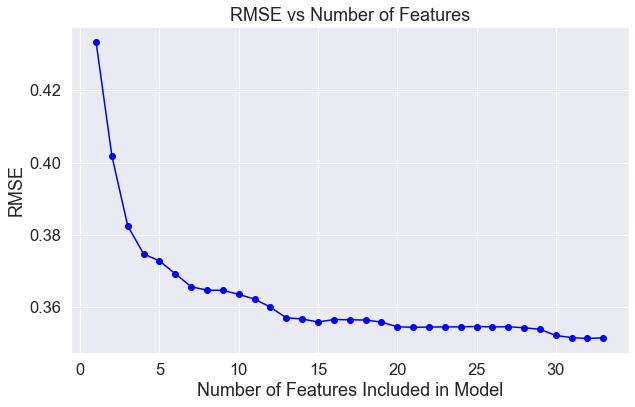

In [54]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(score_board['n_features_to_select'], score_board['test_rmse'], 
        color = 'blue', marker = 'o')
ax.set_xlabel('Number of Features Included in Model')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Number of Features')
plt.show()

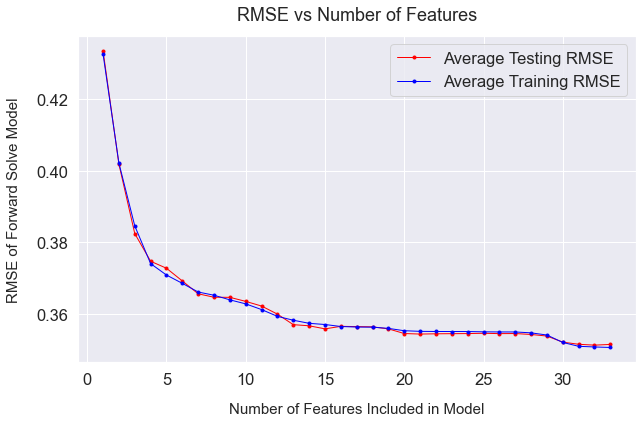

In [55]:
plt.figure(figsize=(10,6))
plt.plot(score_board['n_features_to_select'], score_board['test_rmse'], color="red", label="Average Testing RMSE", linewidth=1, marker='.')
plt.plot(score_board['n_features_to_select'], score_board['train_rmse'], color="blue", label="Average Training RMSE", linewidth=1, marker='.')
# plt.plot(optim_Lambda, best_test_rmse, marker='o', color='goldenrod', alpha=0.4, markersize = 15)
# plt.text(optim_Lambda, best_test_rmse-.04, 'Optimal Lambda: {:.4f}'.format(Lambda[14]), 
#          color='goldenrod')
plt.title("RMSE vs Number of Features", y=1.03)
plt.xlabel("Number of Features Included in Model", fontsize=15, labelpad=15)
plt.ylabel("RMSE of Forward Solve Model", fontsize=15, labelpad=15)
plt.legend()
plt.show()  

### Picking a number of 10 to see if does something

In [56]:
## From the elbow best features could be 10 ? 
best_features[10]

['Pct_Age<18',
 'Pct_Age>=65',
 'Pct_Black',
 'Pct_Asian',
 'Potential_Years_Lost',
 'Pct_Adults_Obsese',
 'Pct_DUI_Deaths',
 'Pct_Uninsured',
 'PrimCarePhys_per_100k',
 'Urbanicity',
 'Prev_Spatial_Mean']

In [34]:
od_nonull = od_nonull.rename(columns={'Pct_Age<18' : 'Pct_Age_18', 'Pct_Age>=65' : 'Pct_Age_65'})

In [61]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Pct_Age_18 + Pct_Age_65 + Pct_Black + Pct_Asian + \
  Potential_Years_Lost + Pct_Adults_Obsese + Pct_DUI_Deaths + Pct_Uninsured +PrimCarePhys_per_100k + \
  Urbanicity + Prev_Spatial_Mean",
                 data=od_nonull, return_type='dataframe')

In [62]:
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [63]:
#this is just with the spatial mean component 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = od_y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.584
Model:                                OLS   Adj. R-squared:                  0.583
Method:                     Least Squares   F-statistic:                     714.9
Date:                    Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                            15:37:31   Log-Likelihood:                -2207.3
No. Observations:                    5622   AIC:                             4439.
Df Residuals:                        5610   BIC:                             4518.
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [64]:
#this is the 
y_test_pred = res.predict(x_test)
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.5799272839971448

In [67]:
y_test_pred = np.array(y_test_pred)
y_test = np.array(y_test).reshape(1875,1)
y_test_pred = np.array(y_test_pred).reshape(1875,1)
compute_rmse(y_test, y_test_pred)

0.37135160646854176

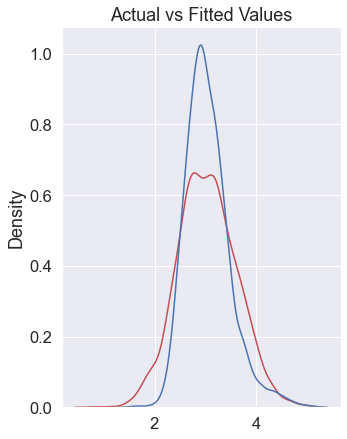

In [68]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

its better but still bad ! we must not do perhaps a backwards stepwise regression ...... could be better we are also getting values in our model that are not significant !! 

### This is now for backwards stepwise regression
here we are going to see how it performs because 

In [70]:
X_columns = od_x.columns
X = np.array(od_x).reshape(7497, 34)
y = np.array(od_y)

In [71]:
kf = KFold(n_splits=2, random_state=0, shuffle=True)
for train_index, test_index in kf.split(od_nonull):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [72]:
train_rmse_list = []
test_rmse_list = []
best_features = []
lr = LinearRegression()

for i in range(1, 34):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                    direction='backward', scoring='neg_mean_squared_error', 
                                    cv = 5)
    sfs.fit(X_train, y_train)

    best_cols = sfs.get_support()
    best_cols = [i for i, x in enumerate(best_cols) if x]
    best_cols = X_columns[best_cols].tolist()
    best_features.append(best_cols)

    X_subset = np.array(od_x[best_cols]).reshape(7497, len(best_cols))
    X_subtrain = X_subset[train_index]
    X_subtest = X_subset[test_index]
    
    lr.fit(X_subtrain, y_train)
    yhat_train = lr.predict(X_subtrain)
    train_rmse = compute_rmse(y_train, yhat_train)
    train_rmse_list.append(train_rmse)
    
    yhat_test = lr.predict(X_subtest)
    test_rmse = compute_rmse(y_test, yhat_test)
    test_rmse_list.append(test_rmse)

best_features_forwards = best_features.copy() 
score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
score_board['test_rmse'] = test_rmse_list
score_board.insert(0, 'n_features_to_select', range(1, 34))
score_board.insert(1, 'best_features', best_features)
score_board

,n_features_to_select,best_features,train_rmse,test_rmse
0,1,[Prev_Spatial_Mean],0.432524,0.433409
1,2,"[Potential_Years_Lost, Prev_Spatial_Mean]",0.402115,0.401817
2,3,"[Pct_Age<18, Potential_Years_Lost, Prev_Spatia...",0.386541,0.386034
3,4,"[Year, Pct_Age<18, Potential_Years_Lost, Prev_...",0.377181,0.373654
4,5,"[Year, Pct_Age<18, Potential_Years_Lost, Pct_P...",0.374089,0.369331
5,6,"[Year, Pct_Age<18, Pct_Black, Potential_Years_...",0.371495,0.367633
6,7,"[Year, Pct_Age<18, Pct_Black, Potential_Years_...",0.368598,0.363108
7,8,"[Year, Pct_Age<18, Pct_Black, Pct_Hispanic, Po...",0.366519,0.361995
8,9,"[Year, Pct_Age<18, Pct_Black, Pct_Hispanic, Po...",0.365435,0.361964
9,10,"[Year, Pct_Age<18, Pct_Black, Pct_Hispanic, Po...",0.362153,0.358879


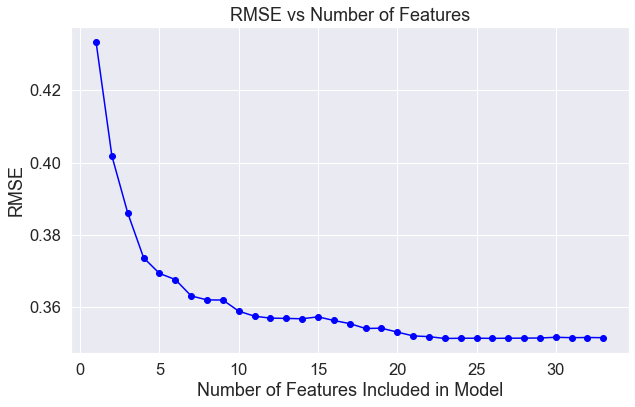

In [73]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(score_board['n_features_to_select'], score_board['test_rmse'], 
        color = 'blue', marker = 'o')
ax.set_xlabel('Number of Features Included in Model')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Number of Features')
plt.show()

In [74]:
## From the elbow best features could be 10 ? 
best_features[10]

['Year',
 'Pct_Age<18',
 'Pct_Black',
 'Pct_Hispanic',
 'Potential_Years_Lost',
 'Pct_DUI_Deaths',
 'Pct_Child_in_1ParentHH',
 'Pct_Unemployed',
 'Pct_Poverty',
 'Urbanicity',
 'Prev_Spatial_Mean']

In [77]:
od_nonull = od_nonull.rename(columns={'Pct_Age<18' : 'Pct_Age_18', 'Pct_Age>=65' : 'Pct_Age_65'})

In [85]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Year + Pct_Age_18 + Pct_Black + Pct_Hispanic + Potential_Years_Lost + \
  Pct_DUI_Deaths + Pct_Child_in_1ParentHH + Pct_Unemployed + Pct_Poverty + \
  Urbanicity + Prev_Spatial_Mean",
                 data=od_nonull, return_type='dataframe')

In [86]:
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [87]:
#this is just with the spatial mean component 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = od_y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.588
Model:                                OLS   Adj. R-squared:                  0.587
Method:                     Least Squares   F-statistic:                     728.7
Date:                    Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                            12:08:33   Log-Likelihood:                -2175.8
No. Observations:                    5622   AIC:                             4376.
Df Residuals:                        5610   BIC:                             4455.
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [88]:
#this is the 
y_test_pred = res.predict(x_test)
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.5901084200382025

In [89]:
y_test_pred = np.array(y_test_pred)
y_test = np.array(y_test).reshape(1875,1)
y_test_pred = np.array(y_test_pred).reshape(1875,1)
compute_rmse(y_test, y_test_pred)

0.3668238529490423

this RMSE is bigger than the one that was from the other model.... but also doesn't seem to be too far off. There are no insignificant predictors in our model though !!  

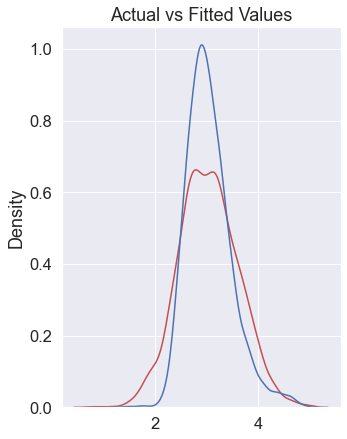

In [90]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

Now we should plot the residuals!!! 

In [26]:
# ### Residual analysis with best subset 
# # plot residuals
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# import matplotlib.pyplot as plt

# best_sub = ['Year',
#  'Pct_Age_18',
#  'Pct_Black',
#  'Pct_Hispanic',
#  'Potential_Years_Lost',
#  'Pct_DUI_Deaths',
#  'Pct_Child_in_1ParentHH',
#  'Pct_Unemployed',
#  'Pct_Poverty',
#  'Urbanicity',
#  'Prev_Spatial_Mean']

# for i in best_sub: 
#     fig = plt.figure(figsize=(14, 8))
#     fig = sm.graphics.plot_regress_exog(res, i,fig=fig)

### We are doing some cross validation with the backwards stepwise seleciton 

In [13]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [15]:
X_int

,Intercept,Population,Pct_Age<18,Pct_Age>=65,Pct_Black,Pct_Native,Pct_Asian,Pct_Pacific_Islander,Pct_Hispanic,Pct_Not_Prof_in_Eng,...,Pct_Children_in_Poverty,Pct_Child_in_1ParentHH,Opioid_Disp_Rate_per_100k,Pct_Unemployed,Pct_Poverty,Median_HHI,Jail_Pop,Urbanicity,Prev_Spatial_Max,Prev_Spatial_Mean
1,1,179878.0,23.100000,17.000000,10.000000,0.500000,0.600000,0.000000,3.300000,1.800000,...,15.1,28.900000,150000.0,9.0,13.4,50144.0,743.36,2.0,26.096714,16.138937
7,1,114081.0,23.400000,15.000000,20.000000,0.400000,0.800000,0.100000,2.600000,1.500000,...,22.9,38.200000,176700.0,10.3,20.9,39060.0,504.25,2.0,17.944086,14.717519
21,1,81778.0,23.300000,15.600000,1.700000,0.500000,0.200000,0.000000,4.400000,2.200000,...,19.7,25.600000,180600.0,9.5,18.2,39395.0,312.43,1.0,50.728854,27.746062
24,1,69380.0,25.500000,14.300000,2.000000,0.800000,0.400000,0.100000,11.700000,5.900000,...,25.1,29.200000,100600.0,11.7,20.3,35487.0,204.54,1.0,14.544185,13.017568
26,1,37434.0,23.000000,15.200000,32.100000,3.100000,0.300000,0.000000,1.500000,0.400000,...,31.7,41.300000,149000.0,10.7,25.5,32838.0,192.75,1.0,15.194356,12.847718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31391,1,135693.0,21.903856,17.985452,1.243985,0.392798,1.459176,0.042744,3.220505,0.497790,...,4.9,21.036707,25100.0,5.6,5.1,81659.0,229.00,3.0,42.401287,20.457328
31392,1,403072.0,21.508564,18.654235,1.590287,0.324012,3.886651,0.054581,4.786986,0.680531,...,4.8,18.233691,41100.0,5.6,4.2,92359.0,350.00,3.0,42.401287,22.396738
31395,1,171020.0,20.515144,16.385218,2.170506,0.746112,3.045843,0.053210,4.200094,0.931389,...,11.6,30.599278,41000.0,5.4,8.7,64653.0,310.00,2.0,12.572169,11.874609
31396,1,73055.0,21.556362,20.562590,0.880159,0.932174,2.003970,0.031483,3.092191,0.717323,...,13.2,28.558645,47400.0,6.7,9.4,54154.0,94.00,1.0,11.791410,11.791410


In [19]:
X_int

,Intercept,Population,Pct_Age<18,Pct_Age>=65,Pct_Black,Pct_Native,Pct_Asian,Pct_Pacific_Islander,Pct_Hispanic,Pct_Not_Prof_in_Eng,...,Pct_Children_in_Poverty,Pct_Child_in_1ParentHH,Opioid_Disp_Rate_per_100k,Pct_Unemployed,Pct_Poverty,Median_HHI,Jail_Pop,Urbanicity,Prev_Spatial_Max,Prev_Spatial_Mean
1,1,179878.0,23.100000,17.000000,10.000000,0.500000,0.600000,0.000000,3.300000,1.800000,...,15.1,28.900000,150000.0,9.0,13.4,50144.0,743.36,2.0,26.096714,16.138937
7,1,114081.0,23.400000,15.000000,20.000000,0.400000,0.800000,0.100000,2.600000,1.500000,...,22.9,38.200000,176700.0,10.3,20.9,39060.0,504.25,2.0,17.944086,14.717519
21,1,81778.0,23.300000,15.600000,1.700000,0.500000,0.200000,0.000000,4.400000,2.200000,...,19.7,25.600000,180600.0,9.5,18.2,39395.0,312.43,1.0,50.728854,27.746062
24,1,69380.0,25.500000,14.300000,2.000000,0.800000,0.400000,0.100000,11.700000,5.900000,...,25.1,29.200000,100600.0,11.7,20.3,35487.0,204.54,1.0,14.544185,13.017568
26,1,37434.0,23.000000,15.200000,32.100000,3.100000,0.300000,0.000000,1.500000,0.400000,...,31.7,41.300000,149000.0,10.7,25.5,32838.0,192.75,1.0,15.194356,12.847718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31391,1,135693.0,21.903856,17.985452,1.243985,0.392798,1.459176,0.042744,3.220505,0.497790,...,4.9,21.036707,25100.0,5.6,5.1,81659.0,229.00,3.0,42.401287,20.457328
31392,1,403072.0,21.508564,18.654235,1.590287,0.324012,3.886651,0.054581,4.786986,0.680531,...,4.8,18.233691,41100.0,5.6,4.2,92359.0,350.00,3.0,42.401287,22.396738
31395,1,171020.0,20.515144,16.385218,2.170506,0.746112,3.045843,0.053210,4.200094,0.931389,...,11.6,30.599278,41000.0,5.4,8.7,64653.0,310.00,2.0,12.572169,11.874609
31396,1,73055.0,21.556362,20.562590,0.880159,0.932174,2.003970,0.031483,3.092191,0.717323,...,13.2,28.558645,47400.0,6.7,9.4,54154.0,94.00,1.0,11.791410,11.791410


In [20]:
train_rmse_list = []
test_rmse_list = []
best_features = []
n_features_list  = []
cv_round_list = []
lr = LinearRegression()

y = od_y
X_int = od_x
#X_int.insert(0, 'Intercept', 1)

X = np.array(X_int)
y = np.array(np.log(y))
X_columns = X_int.columns

cv_round = 0


# kf = KFold(n_splits=5, random_state=0, shuffle=True)
# for train_index, test_index in kf.split(od_nonull):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     cv_round = cv_round + 1 
    
#     for i in range(1, 33):
        
#         sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
#                                         direction='backward', scoring='neg_mean_squared_error', 
#                                         cv = 5)
#         sfs.fit(X_train, y_train)

#         best_cols = sfs.get_support()
#         best_cols = [i for i, x in enumerate(best_cols) if x]
#         best_cols = X_columns[best_cols].tolist()
#         best_features.append(best_cols)

#         X_subset = np.array(X_int[best_cols]).reshape(od_nonull.shape[0], len(best_cols))
#         X_subtrain = X_subset[train_index]
#         X_subtest = X_subset[test_index]

#         lr.fit(X_subtrain, y_train)
#         yhat_train = lr.predict(X_subtrain)
#         train_rmse = np.sqrt(mean_squared_error(y_train, yhat_train))
#         train_rmse_list.append(train_rmse)

#         yhat_test = lr.predict(X_subtest)
#         test_rmse = np.sqrt(mean_squared_error(y_test, yhat_test))
#         test_rmse_list.append(test_rmse)
        
#         n_features_list.append(i)
#         cv_round_list.append(cv_round)

# best_features_naive = best_features.copy() 
# score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
# score_board['test_rmse'] = test_rmse_list
# score_board.insert(0, 'n_features', n_features_list)
# score_board.insert(1, 'best_features', best_features)
# score_board.insert(0, 'cv_round', cv_round_list)
# score_board_naive = score_board.copy()
# score_board_naive

,cv_round,n_features,best_features,train_rmse,test_rmse
0,1,1,[Prev_Spatial_Mean],0.152432,0.152076
1,1,2,"[Potential_Years_Lost, Prev_Spatial_Mean]",0.142467,0.143756
2,1,3,"[Potential_Years_Lost, Pct_Uninsured, Prev_Spa...",0.135816,0.137000
3,1,4,"[Pct_Age<18, Potential_Years_Lost, Pct_Uninsur...",0.131747,0.132427
4,1,5,"[Pct_Age<18, Potential_Years_Lost, Pct_Uninsur...",0.129657,0.130385
...,...,...,...,...,...
155,5,28,"[Intercept, Population, Pct_Age<18, Pct_Black,...",0.124533,0.123198
156,5,29,"[Intercept, Population, Pct_Age<18, Pct_Black,...",0.124527,0.123196
157,5,30,"[Intercept, Population, Pct_Age<18, Pct_Black,...",0.124453,0.123256
158,5,31,"[Intercept, Population, Pct_Age<18, Pct_Black,...",0.124413,0.123301


In [54]:
for i in score_board_naive[score_board_naive['n_features'] == 8]['best_features']:
    print(i)

['Pct_Age<18', 'Pct_Black', 'Potential_Years_Lost', 'Pct_Uninsured', 'PrimCarePhys_per_100k', 'Pct_Child_in_1ParentHH', 'Pct_Poverty', 'Prev_Spatial_Mean']
['Pct_Age<18', 'Pct_Black', 'Potential_Years_Lost', 'Pct_Uninsured', 'PrimCarePhys_per_100k', 'Pct_Child_in_1ParentHH', 'Pct_Poverty', 'Prev_Spatial_Mean']
['Pct_Age<18', 'Pct_Black', 'Potential_Years_Lost', 'Pct_Uninsured', 'PrimCarePhys_per_100k', 'Pct_Child_in_1ParentHH', 'Pct_Poverty', 'Prev_Spatial_Mean']
['Pct_Age<18', 'Pct_Black', 'Potential_Years_Lost', 'Pct_Uninsured', 'PrimCarePhys_per_100k', 'Pct_Child_in_1ParentHH', 'Pct_Poverty', 'Prev_Spatial_Mean']
['Pct_Age<18', 'Pct_Black', 'Potential_Years_Lost', 'Pct_Uninsured', 'PrimCarePhys_per_100k', 'Pct_Child_in_1ParentHH', 'Pct_Poverty', 'Prev_Spatial_Mean']


In [21]:
score_naive_means = score_board_naive.groupby('n_features').mean().reset_index()
score_naive_means

,n_features,cv_round,train_rmse,test_rmse
0,1,3.0,0.152352,0.152371
1,2,3.0,0.142713,0.142754
2,3,3.0,0.136181,0.136043
3,4,3.0,0.132183,0.132147
4,5,3.0,0.130324,0.130563
5,6,3.0,0.129331,0.129969
6,7,3.0,0.128517,0.129197
7,8,3.0,0.127041,0.127211
8,9,3.0,0.126655,0.126844
9,10,3.0,0.126236,0.126731


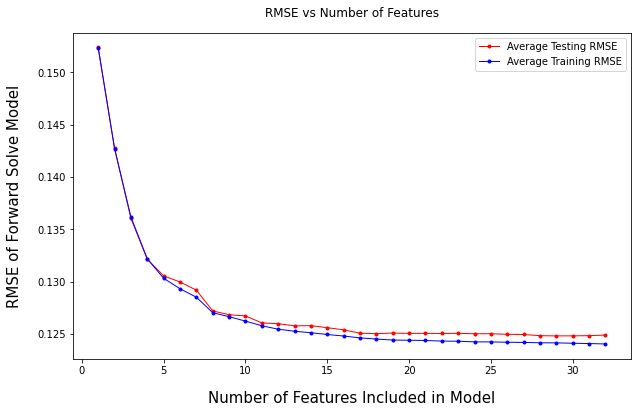

In [23]:
plt.figure(figsize=(10,6))
plt.plot(score_naive_means['n_features'], score_naive_means['test_rmse'], color="red", label="Average Testing RMSE", linewidth=1, marker='.')
plt.plot(score_naive_means['n_features'], score_naive_means['train_rmse'], color="blue", label="Average Training RMSE", linewidth=1, marker='.')
# plt.plot(optim_Lambda, best_test_rmse, marker='o', color='goldenrod', alpha=0.4, markersize = 15)
# plt.text(optim_Lambda, best_test_rmse-.04, 'Optimal Lambda: {:.4f}'.format(Lambda[14]), 
#          color='goldenrod')
plt.title("RMSE vs Number of Features", y=1.03)
plt.xlabel("Number of Features Included in Model", fontsize=15, labelpad=15)
plt.ylabel("RMSE of Forward Solve Model", fontsize=15, labelpad=15)
plt.legend()
plt.show()  

Here we will pick a value of about 9 or 10 as our optimal values to include from our model. 

- should check to make sure that the variables you get from the forward selection are the same-ish as the ones that you get from the backwards selectio. 

In [16]:
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn.metrics import r2_score 

In [17]:
od_nonull = od_nonull.rename(columns={'Pct_Age<18' : 'Pct_Age_18', 'Pct_Age>=65' : 'Pct_Age_65'})

In [19]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Pct_Age_18 + Pct_Black + Potential_Years_Lost + \
  Pct_Uninsured + PrimCarePhys_per_100k + Pct_Child_in_1ParentHH + \
  Pct_Poverty + Prev_Spatial_Mean",
                 data=od_nonull, return_type='dataframe')

In [20]:
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [21]:
#this is just with the spatial mean component 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = od_y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.586
Model:                                OLS   Adj. R-squared:                  0.586
Method:                     Least Squares   F-statistic:                     993.6
Date:                    Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                            14:01:04   Log-Likelihood:                -2190.6
No. Observations:                    5622   AIC:                             4399.
Df Residuals:                        5613   BIC:                             4459.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [22]:
#this is the 
y_test_pred = res.predict(x_test)
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.5833734063176949

In [23]:
y_test_pred = np.array(y_test_pred)
y_test = np.array(y_test).reshape(1875,1)
y_test_pred = np.array(y_test_pred).reshape(1875,1)
compute_rmse(y_test, y_test_pred)

0.36982525349842793

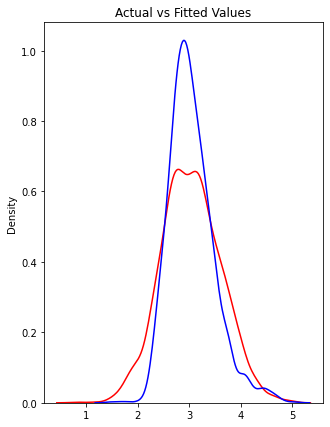

In [24]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

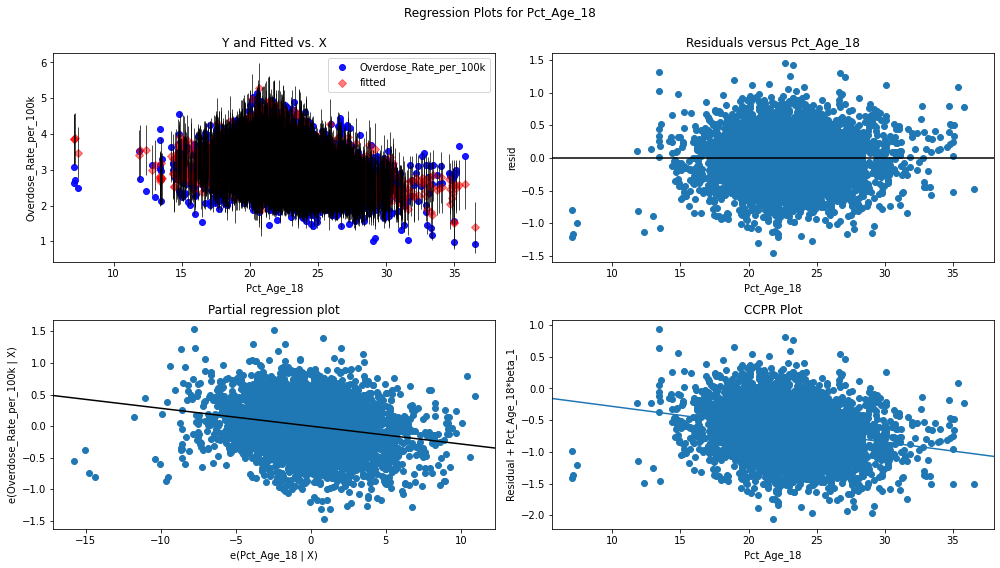

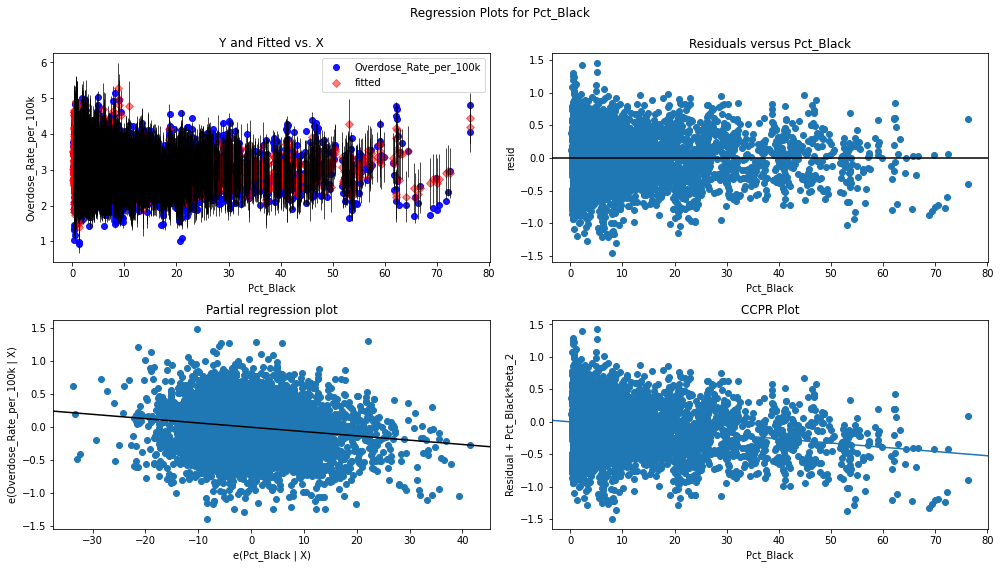

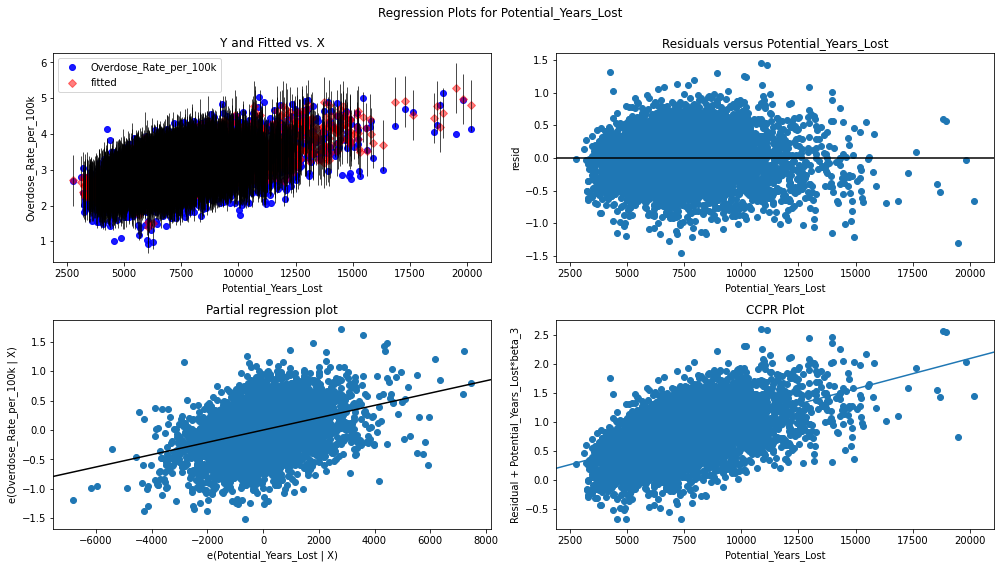

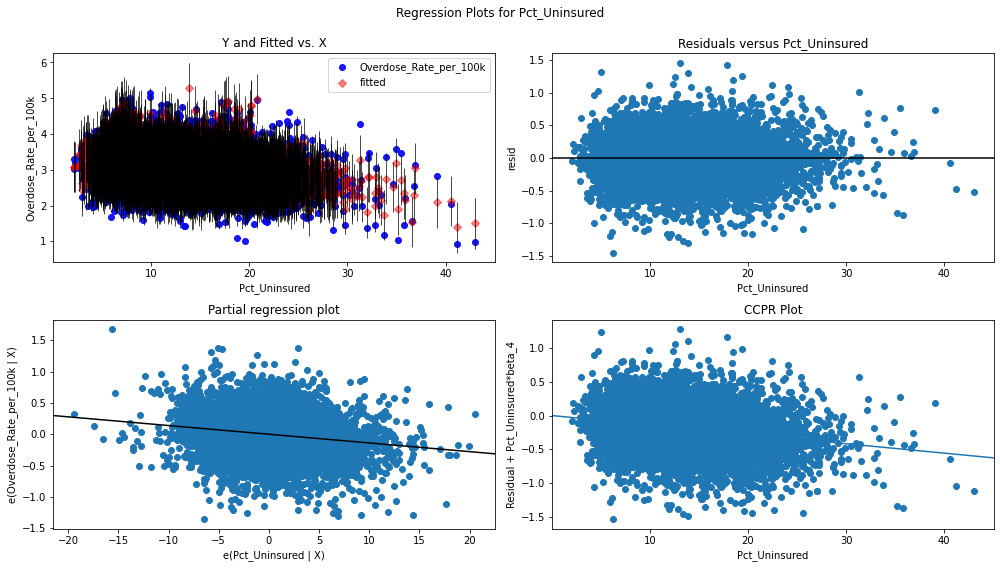

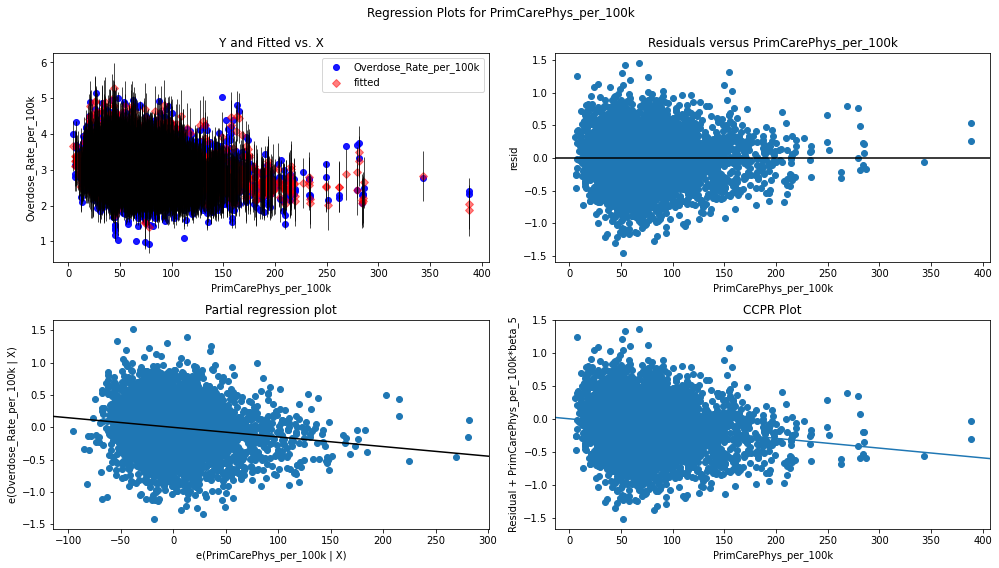

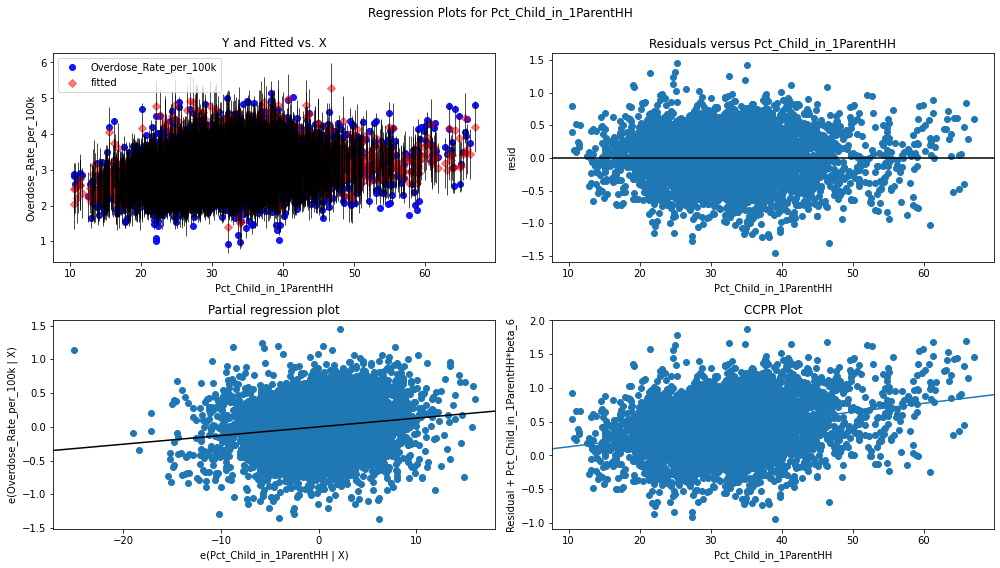

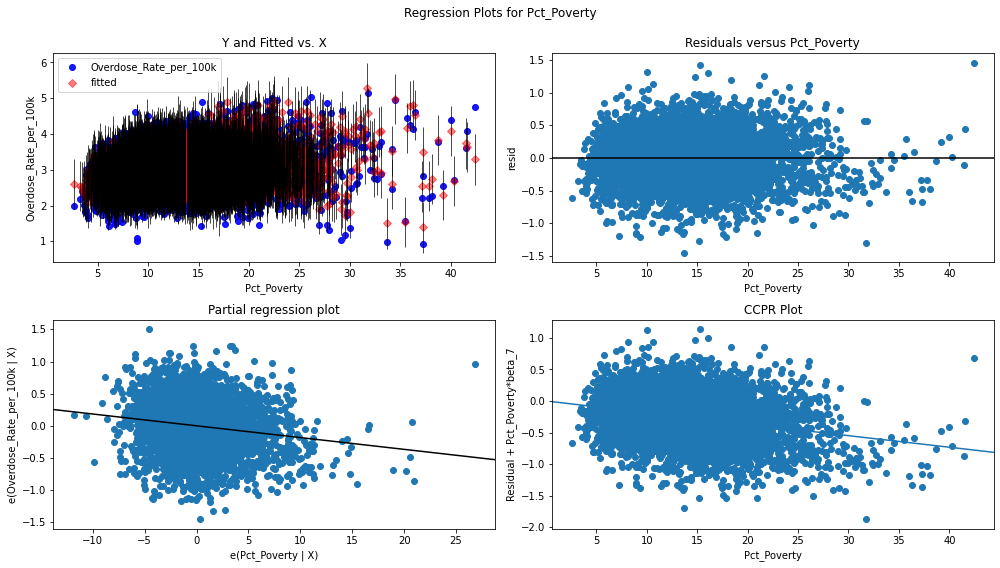

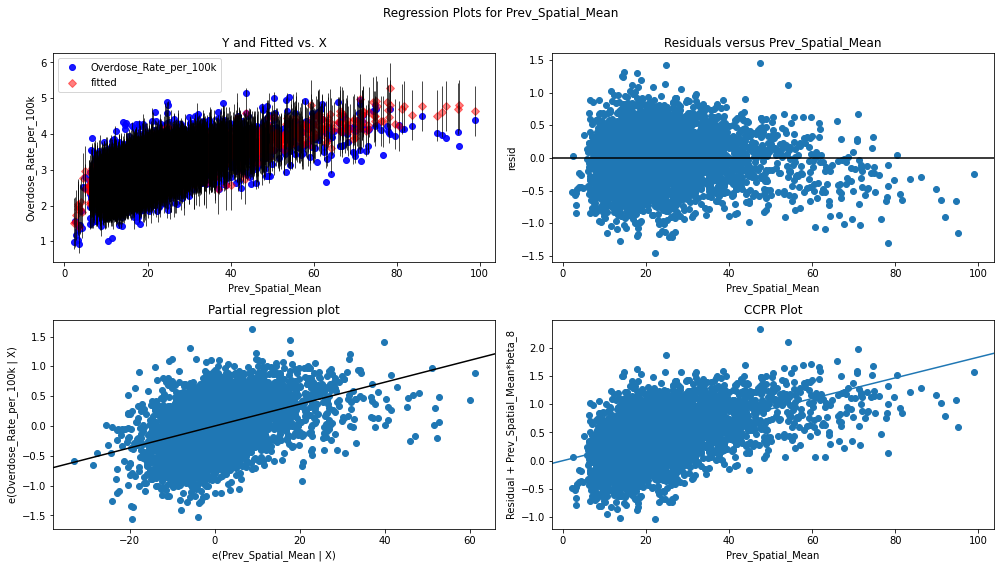

In [25]:
### Residual analysis with best subset 
# plot residuals
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

best_sub = ['Pct_Age_18', 'Pct_Black', 'Potential_Years_Lost', 
             'Pct_Uninsured', 
            'PrimCarePhys_per_100k', 
            'Pct_Child_in_1ParentHH', 'Pct_Poverty', 
            'Prev_Spatial_Mean']

for i in best_sub: 
    fig = plt.figure(figsize=(14, 8))
    fig = sm.graphics.plot_regress_exog(res, i,fig=fig)

In [26]:
od_nonull.columns

Index(['Year', 'FIPS', 'County', 'State', 'Region', 'Division',
       'Overdose_Deaths', 'Overdose_Pop', 'Overdose_Rate_per_100k',
       'Population', 'Pct_Age_18', 'Pct_Age_65', 'Pct_Black', 'Pct_Native',
       'Pct_Asian', 'Pct_Pacific_Islander', 'Pct_Hispanic',
       'Pct_Not_Prof_in_Eng', 'Pct_Female', 'Pct_Rural', 'Pct_Diabetes',
       'Potential_Years_Lost', 'Pct_Low_Weight_Births', 'Pct_Smokers',
       'Pct_Adults_Obsese', 'Pct_Excessive_Drinking', 'Pct_DUI_Deaths',
       'Teen_Birth_Rate_per_100k', 'Pct_Uninsured', 'PrimCarePhys_per_100k',
       'Pct_HS_Grad', 'Pct_College_Edu', 'Pct_Children_in_Poverty',
       'Pct_Child_in_1ParentHH', 'Opioid_Disp_Rate_per_100k', 'Pct_Unemployed',
       'Pct_Poverty', 'Median_HHI', 'Jail_Pop', 'Urbanicity', 'Spatial_Max',
       'Spatial_Mean', 'Prev_Spatial_Max', 'Prev_Spatial_Mean', 'Geometry'],
      dtype='object')

<AxesSubplot:xlabel='Prev_Spatial_Mean', ylabel='Overdose_Rate_per_100k'>

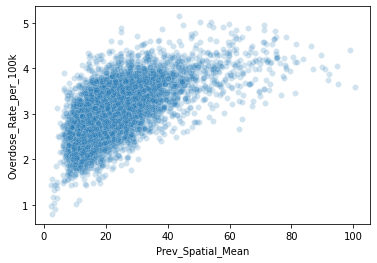

In [40]:
import seaborn as sns
y = np.log(od_nonull['Overdose_Rate_per_100k'])
sns.scatterplot(x = 'Prev_Spatial_Mean', y = y, data = od_nonull, alpha = 0.2)

<AxesSubplot:xlabel='Prev_Spatial_Mean', ylabel='Overdose_Rate_per_100k'>

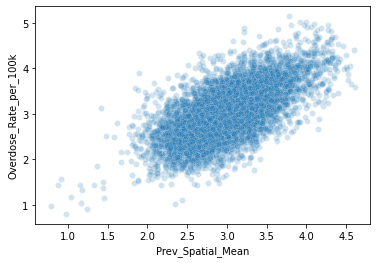

In [41]:
# we should log this and log other things like spat mean toooooooo xoxo GOSSIP GIRL 

a = np.log(od_nonull['Prev_Spatial_Mean']) 
b = np.log(od_nonull['Overdose_Rate_per_100k'])

sns.scatterplot(x = a, y = b, alpha = 0.2)

Me and Wei found 
 - Log transform the percent black 
 - log tranform the potential years lost 
 - no tranform to the percent uninsured 
 - no tranform to the percent age 18 
 - log the prime care physician per 100k 
 - no tranform percent child in 1 parent house hld 
 - log the percent poverty guy 
 - log the previous spatial mean guy 

### Now going to have a new model that has the transform of the variables now 

In [42]:
od_nonull.columns

Index(['Year', 'FIPS', 'County', 'State', 'Region', 'Division',
       'Overdose_Deaths', 'Overdose_Pop', 'Overdose_Rate_per_100k',
       'Population', 'Pct_Age_18', 'Pct_Age_65', 'Pct_Black', 'Pct_Native',
       'Pct_Asian', 'Pct_Pacific_Islander', 'Pct_Hispanic',
       'Pct_Not_Prof_in_Eng', 'Pct_Female', 'Pct_Rural', 'Pct_Diabetes',
       'Potential_Years_Lost', 'Pct_Low_Weight_Births', 'Pct_Smokers',
       'Pct_Adults_Obsese', 'Pct_Excessive_Drinking', 'Pct_DUI_Deaths',
       'Teen_Birth_Rate_per_100k', 'Pct_Uninsured', 'PrimCarePhys_per_100k',
       'Pct_HS_Grad', 'Pct_College_Edu', 'Pct_Children_in_Poverty',
       'Pct_Child_in_1ParentHH', 'Opioid_Disp_Rate_per_100k', 'Pct_Unemployed',
       'Pct_Poverty', 'Median_HHI', 'Jail_Pop', 'Urbanicity', 'Spatial_Max',
       'Spatial_Mean', 'Prev_Spatial_Max', 'Prev_Spatial_Mean', 'Geometry'],
      dtype='object')

In [47]:
od_nonull['log_Pct_Black'] = np.log(od_nonull['Pct_Black'])
od_nonull['log_Potential_Years_Lost'] = np.log(od_nonull['Potential_Years_Lost'])
od_nonull['log_PrimCarePhys_per_100k'] = np.log(od_nonull['PrimCarePhys_per_100k'])
od_nonull['log_Pct_Poverty'] = np.log(od_nonull['Pct_Poverty'])
od_nonull['log_Prev_Spatial_Mean'] = np.log(od_nonull['Prev_Spatial_Mean'])

In [48]:
od_nonull.columns

Index(['Year', 'FIPS', 'County', 'State', 'Region', 'Division',
       'Overdose_Deaths', 'Overdose_Pop', 'Overdose_Rate_per_100k',
       'Population', 'Pct_Age_18', 'Pct_Age_65', 'Pct_Black', 'Pct_Native',
       'Pct_Asian', 'Pct_Pacific_Islander', 'Pct_Hispanic',
       'Pct_Not_Prof_in_Eng', 'Pct_Female', 'Pct_Rural', 'Pct_Diabetes',
       'Potential_Years_Lost', 'Pct_Low_Weight_Births', 'Pct_Smokers',
       'Pct_Adults_Obsese', 'Pct_Excessive_Drinking', 'Pct_DUI_Deaths',
       'Teen_Birth_Rate_per_100k', 'Pct_Uninsured', 'PrimCarePhys_per_100k',
       'Pct_HS_Grad', 'Pct_College_Edu', 'Pct_Children_in_Poverty',
       'Pct_Child_in_1ParentHH', 'Opioid_Disp_Rate_per_100k', 'Pct_Unemployed',
       'Pct_Poverty', 'Median_HHI', 'Jail_Pop', 'Urbanicity', 'Spatial_Max',
       'Spatial_Mean', 'Prev_Spatial_Max', 'Prev_Spatial_Mean', 'Geometry',
       'log_Pct_Black', 'log_Potential_Years_Lost',
       'log_PrimCarePhys_per_100k', 'log_Pct_Poverty',
       'log_Prev_Spatial_Mean']

In [49]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Pct_Age_18 + log_Pct_Black + log_Potential_Years_Lost + \
  Pct_Uninsured + log_PrimCarePhys_per_100k + Pct_Child_in_1ParentHH + \
  log_Pct_Poverty + log_Prev_Spatial_Mean",
                 data=od_nonull, return_type='dataframe')

In [50]:
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [51]:
#this is just with the spatial mean component 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = od_y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.599
Model:                                OLS   Adj. R-squared:                  0.599
Method:                     Least Squares   F-statistic:                     1050.
Date:                    Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                            14:30:48   Log-Likelihood:                -2098.3
No. Observations:                    5622   AIC:                             4215.
Df Residuals:                        5613   BIC:                             4274.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [63]:
y_pred_full = res.predict(X)

In [52]:
#this is the 
y_test_pred = res.predict(x_test)
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.6047621168733097

In [53]:
y_test_pred = np.array(y_test_pred)
y_test = np.array(y_test).reshape(1875,1)
y_test_pred = np.array(y_test_pred).reshape(1875,1)
compute_rmse(y_test, y_test_pred)

0.3602071688682112

In [60]:
resid = pd.DataFrame(y_test -  y_test_pred)
resid

,0
0,-0.600399
1,0.072623
2,-0.056013
3,-0.035461
4,0.426531
...,...
1870,-0.270773
1871,-0.337836
1872,-0.151835
1873,0.047278


In [61]:
od_nonull

,Year,FIPS,County,State,Region,Division,Overdose_Deaths,Overdose_Pop,Overdose_Rate_per_100k,Population,...,Spatial_Max,Spatial_Mean,Prev_Spatial_Max,Prev_Spatial_Mean,Geometry,log_Pct_Black,log_Potential_Years_Lost,log_PrimCarePhys_per_100k,log_Pct_Poverty,log_Prev_Spatial_Mean
1,2011,1003,"Baldwin County, AL",Alabama,South,East South Central,24.0,186717.0,12.853677,179878.0,...,42.000263,21.667119,26.096714,16.138937,"POLYGON ((-87.598927 30.997454, -87.594111 30....",2.302585,9.026634,4.794964,2.595255,2.781235
7,2011,1015,"Calhoun County, AL",Alabama,South,East South Central,14.0,117797.0,11.884853,114081.0,...,21.327520,17.854349,17.944086,14.717519,"POLYGON ((-86.145562 33.679098, -86.043993 33....",2.995732,9.369018,4.653008,3.039749,2.689039
21,2011,1043,"Cullman County, AL",Alabama,South,East South Central,10.0,80536.0,12.416807,81778.0,...,55.504718,34.421638,50.728854,27.746062,"POLYGON ((-87.109911 34.299299, -87.110111 34....",0.530628,9.165835,4.347694,2.901422,3.323094
24,2011,1049,"De Kalb County, AL",Alabama,South,East South Central,11.0,71375.0,15.411559,69380.0,...,17.429700,15.905439,14.544185,13.017568,"POLYGON ((-85.513709 34.52417, -85.513699 34.5...",0.693147,9.203346,3.806662,3.010621,2.566300
26,2011,1053,"Escambia County, AL",Alabama,South,East South Central,16.0,38095.0,42.000263,37434.0,...,16.222811,13.108417,15.194356,12.847718,"POLYGON ((-87.163084 30.999051, -87.25498 30.9...",3.468856,9.291312,4.347694,3.238678,2.553166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31391,2020,55131,"Washington County, WI",Wisconsin,Midwest,East North Central,31.0,136445.0,22.719777,135693.0,...,53.649885,29.180797,42.401287,20.457328,"POLYGON ((-88.040528 43.542361, -88.063353 43....",0.218320,8.480592,4.003213,1.629241,3.018341
31392,2020,55133,"Waukesha County, WI",Wisconsin,Midwest,East North Central,97.0,406172.0,23.881508,403072.0,...,53.649885,28.667630,42.401287,22.396738,"POLYGON ((-88.542026 42.93094, -88.539619 43.1...",0.463914,8.478929,4.931122,1.435085,3.108915
31395,2020,55139,"Winnebago County, WI",Wisconsin,Midwest,East North Central,38.0,171631.0,22.140522,171020.0,...,26.238557,20.006112,12.572169,11.874609,"POLYGON ((-88.404043 44.226903, -88.404425 44....",0.774960,8.689358,4.386920,2.163323,2.474402
31396,2020,55141,"Wood County, WI",Wisconsin,Midwest,East North Central,18.0,72560.0,24.807056,73055.0,...,10.325017,10.325017,11.791410,11.791410,"POLYGON ((-89.902565 44.24947, -90.312035 44.2...",-0.127653,8.858244,4.995117,2.240710,2.467371


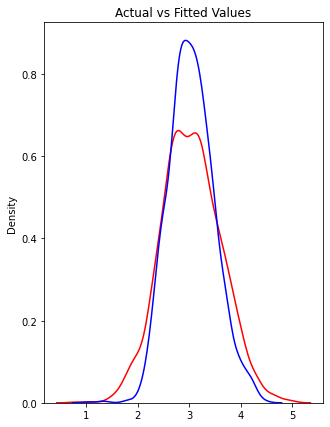

In [54]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

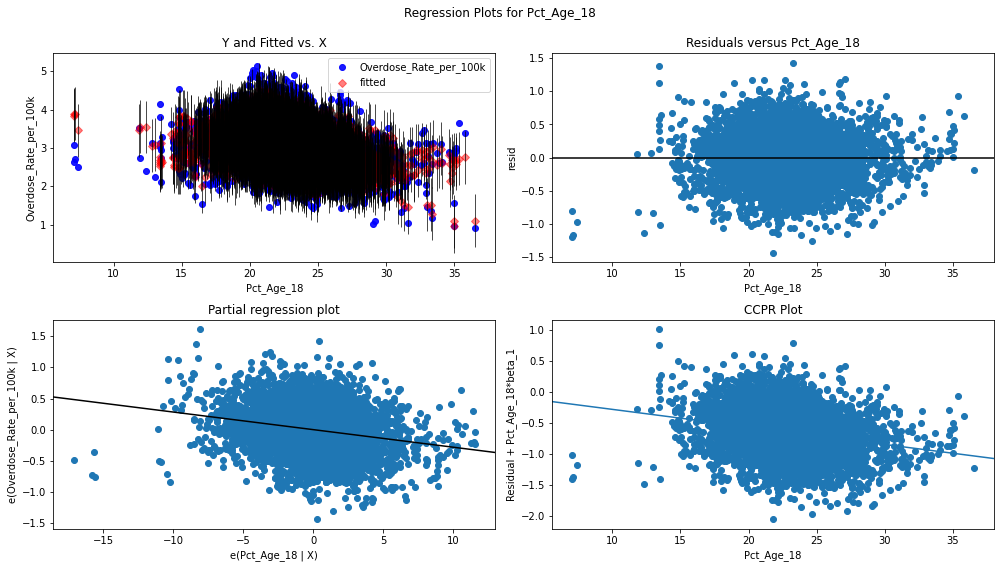

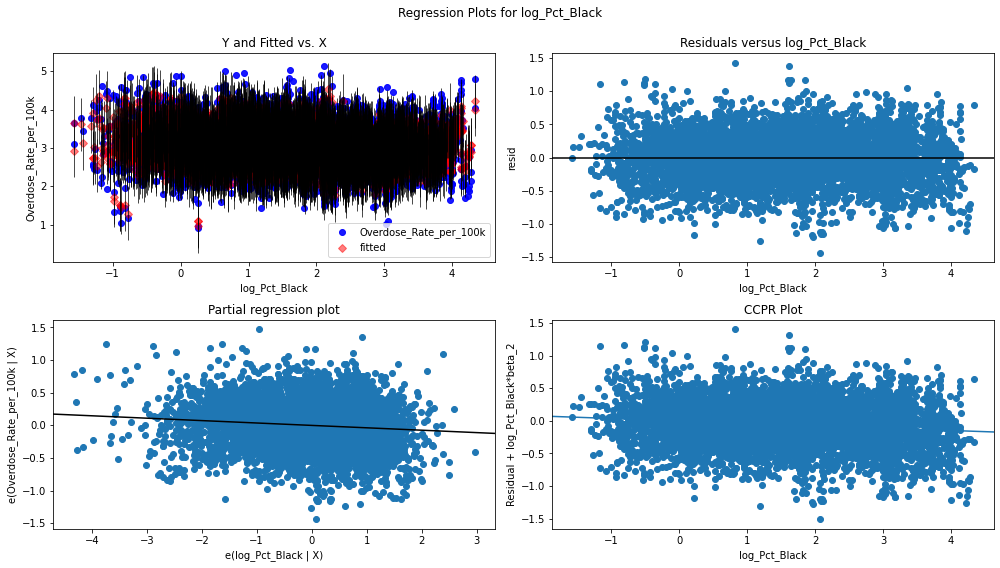

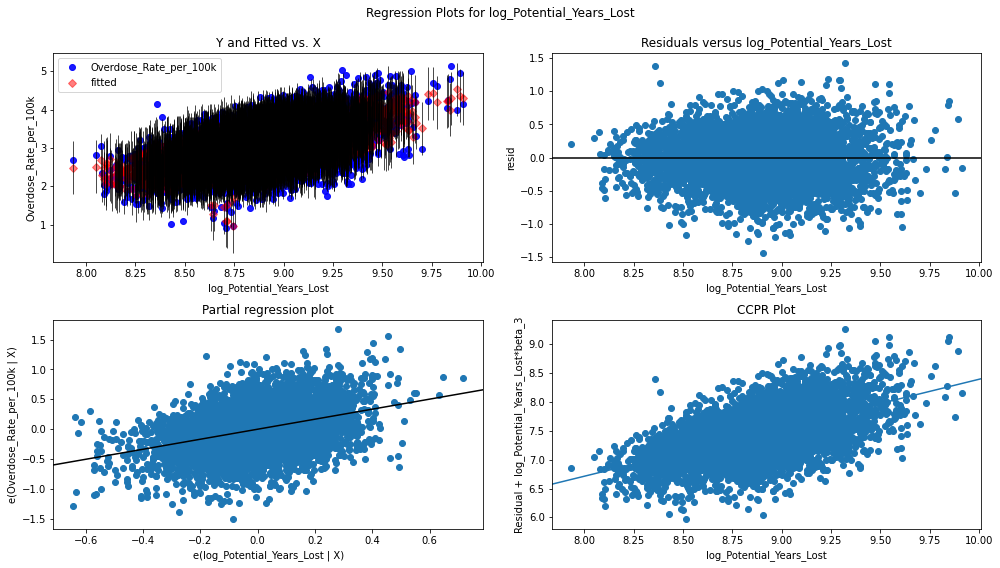

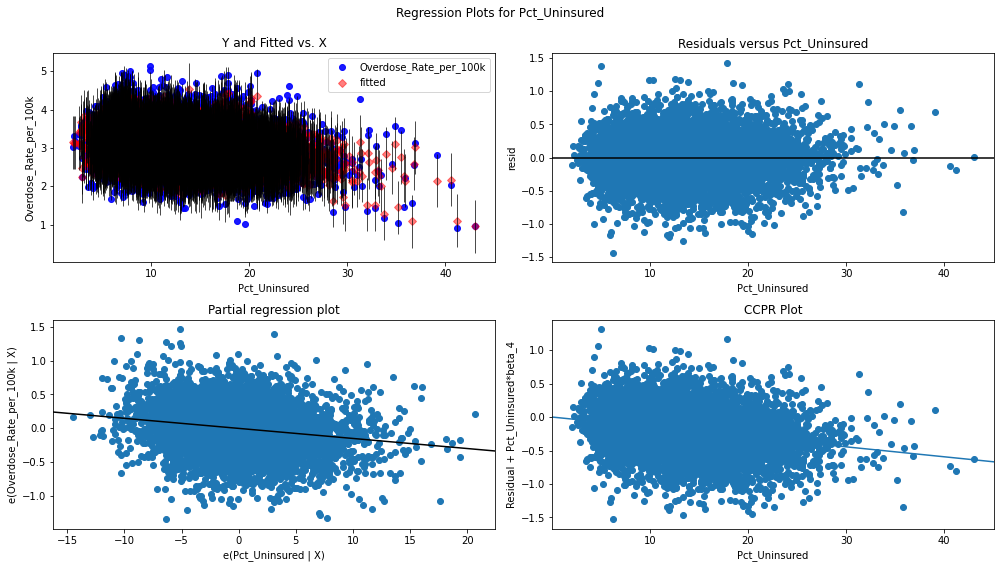

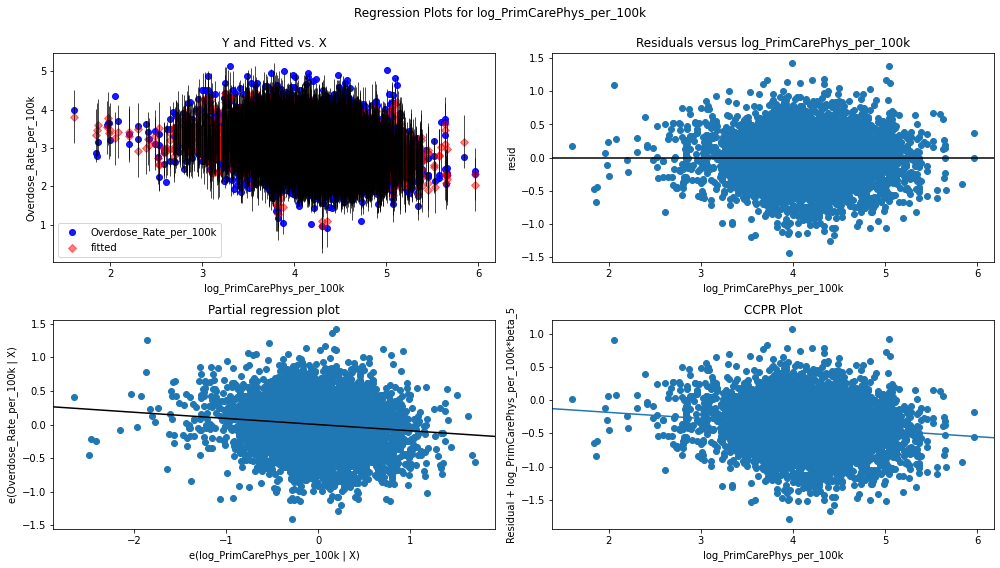

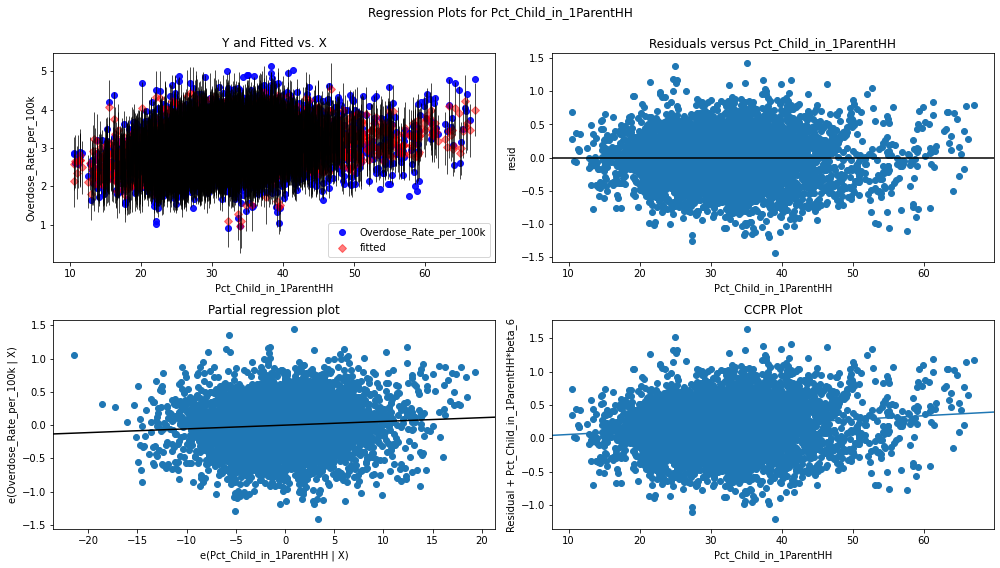

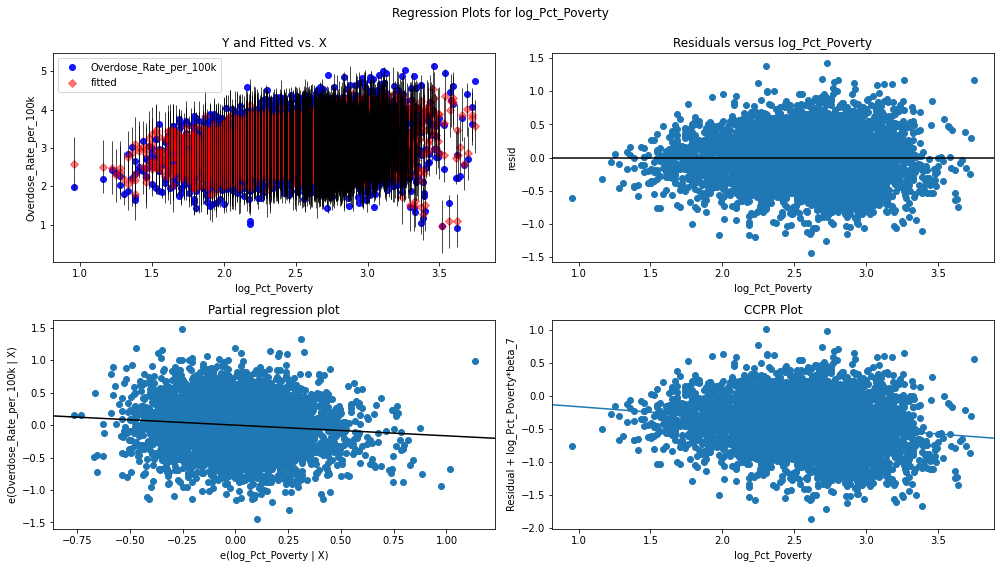

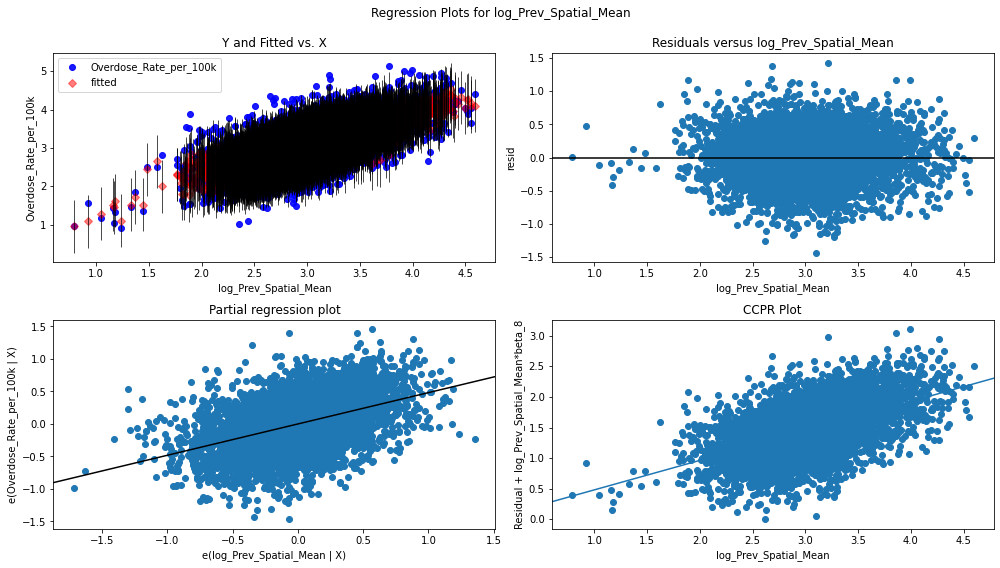

In [55]:
### Residual analysis with best subset 
# plot residuals
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

best_sub = ['Pct_Age_18', 'log_Pct_Black', 'log_Potential_Years_Lost', 
            'Pct_Uninsured', 
            'log_PrimCarePhys_per_100k', 
            'Pct_Child_in_1ParentHH', 'log_Pct_Poverty', 
            'log_Prev_Spatial_Mean']

for i in best_sub: 
    fig = plt.figure(figsize=(14, 8))
    fig = sm.graphics.plot_regress_exog(res, i,fig=fig)

### Code for plotting the residuals on a map 

In [105]:
#putting the residuals in one column of a dataframe !! 
y = np.array(y).reshape(7497, 1)
y_pred_full = y_pred_full.reshape(7497,1)
resid = pd.DataFrame(y -  y_pred_full)
resid

,0
0,-0.277667
1,-0.635590
2,-0.754209
3,-0.153094
4,0.792528
...,...
7492,0.089783
7493,0.158608
7494,0.218754
7495,0.272947


In [174]:
#Append it top the whole dataframe 
od_nonull = od_nonull.reset_index(drop = True)
od_nonull['Residuals'] = resid

In [147]:
od_nonull = od_nonull.rename(columns={'Geometry':'geometry'})
od_nonull = od_nonull.rename(columns={'Pct_Age<18' : 'Pct_Age_18', 'Pct_Age>=65' : 'Pct_Age_65'})
od_nonull.dtypes

Year                           int64
FIPS                           int64
County                        object
State                         object
Region                        object
Division                      object
Overdose_Deaths              float64
Overdose_Pop                 float64
Overdose_Rate_per_100k       float64
Population                   float64
Pct_Age<18                   float64
Pct_Age>=65                  float64
Pct_Black                    float64
Pct_Native                   float64
Pct_Asian                    float64
Pct_Pacific_Islander         float64
Pct_Hispanic                 float64
Pct_Not_Prof_in_Eng          float64
Pct_Female                   float64
Pct_Rural                    float64
Pct_Diabetes                 float64
Potential_Years_Lost         float64
Pct_Low_Weight_Births        float64
Pct_Smokers                  float64
Pct_Adults_Obsese            float64
Pct_Excessive_Drinking       float64
Pct_DUI_Deaths               float64
T

In [153]:
import geopandas as gpd
import contextily as cx

In [149]:
from shapely import wkt
# You have to use the od_nonull file that is in the Data otherwise wont work 

od_nonull['geometry'] = od_nonull['geometry'].apply(wkt.loads)
geo_od_nonull = gpd.GeoDataFrame(od_nonull, crs='epsg:4326')

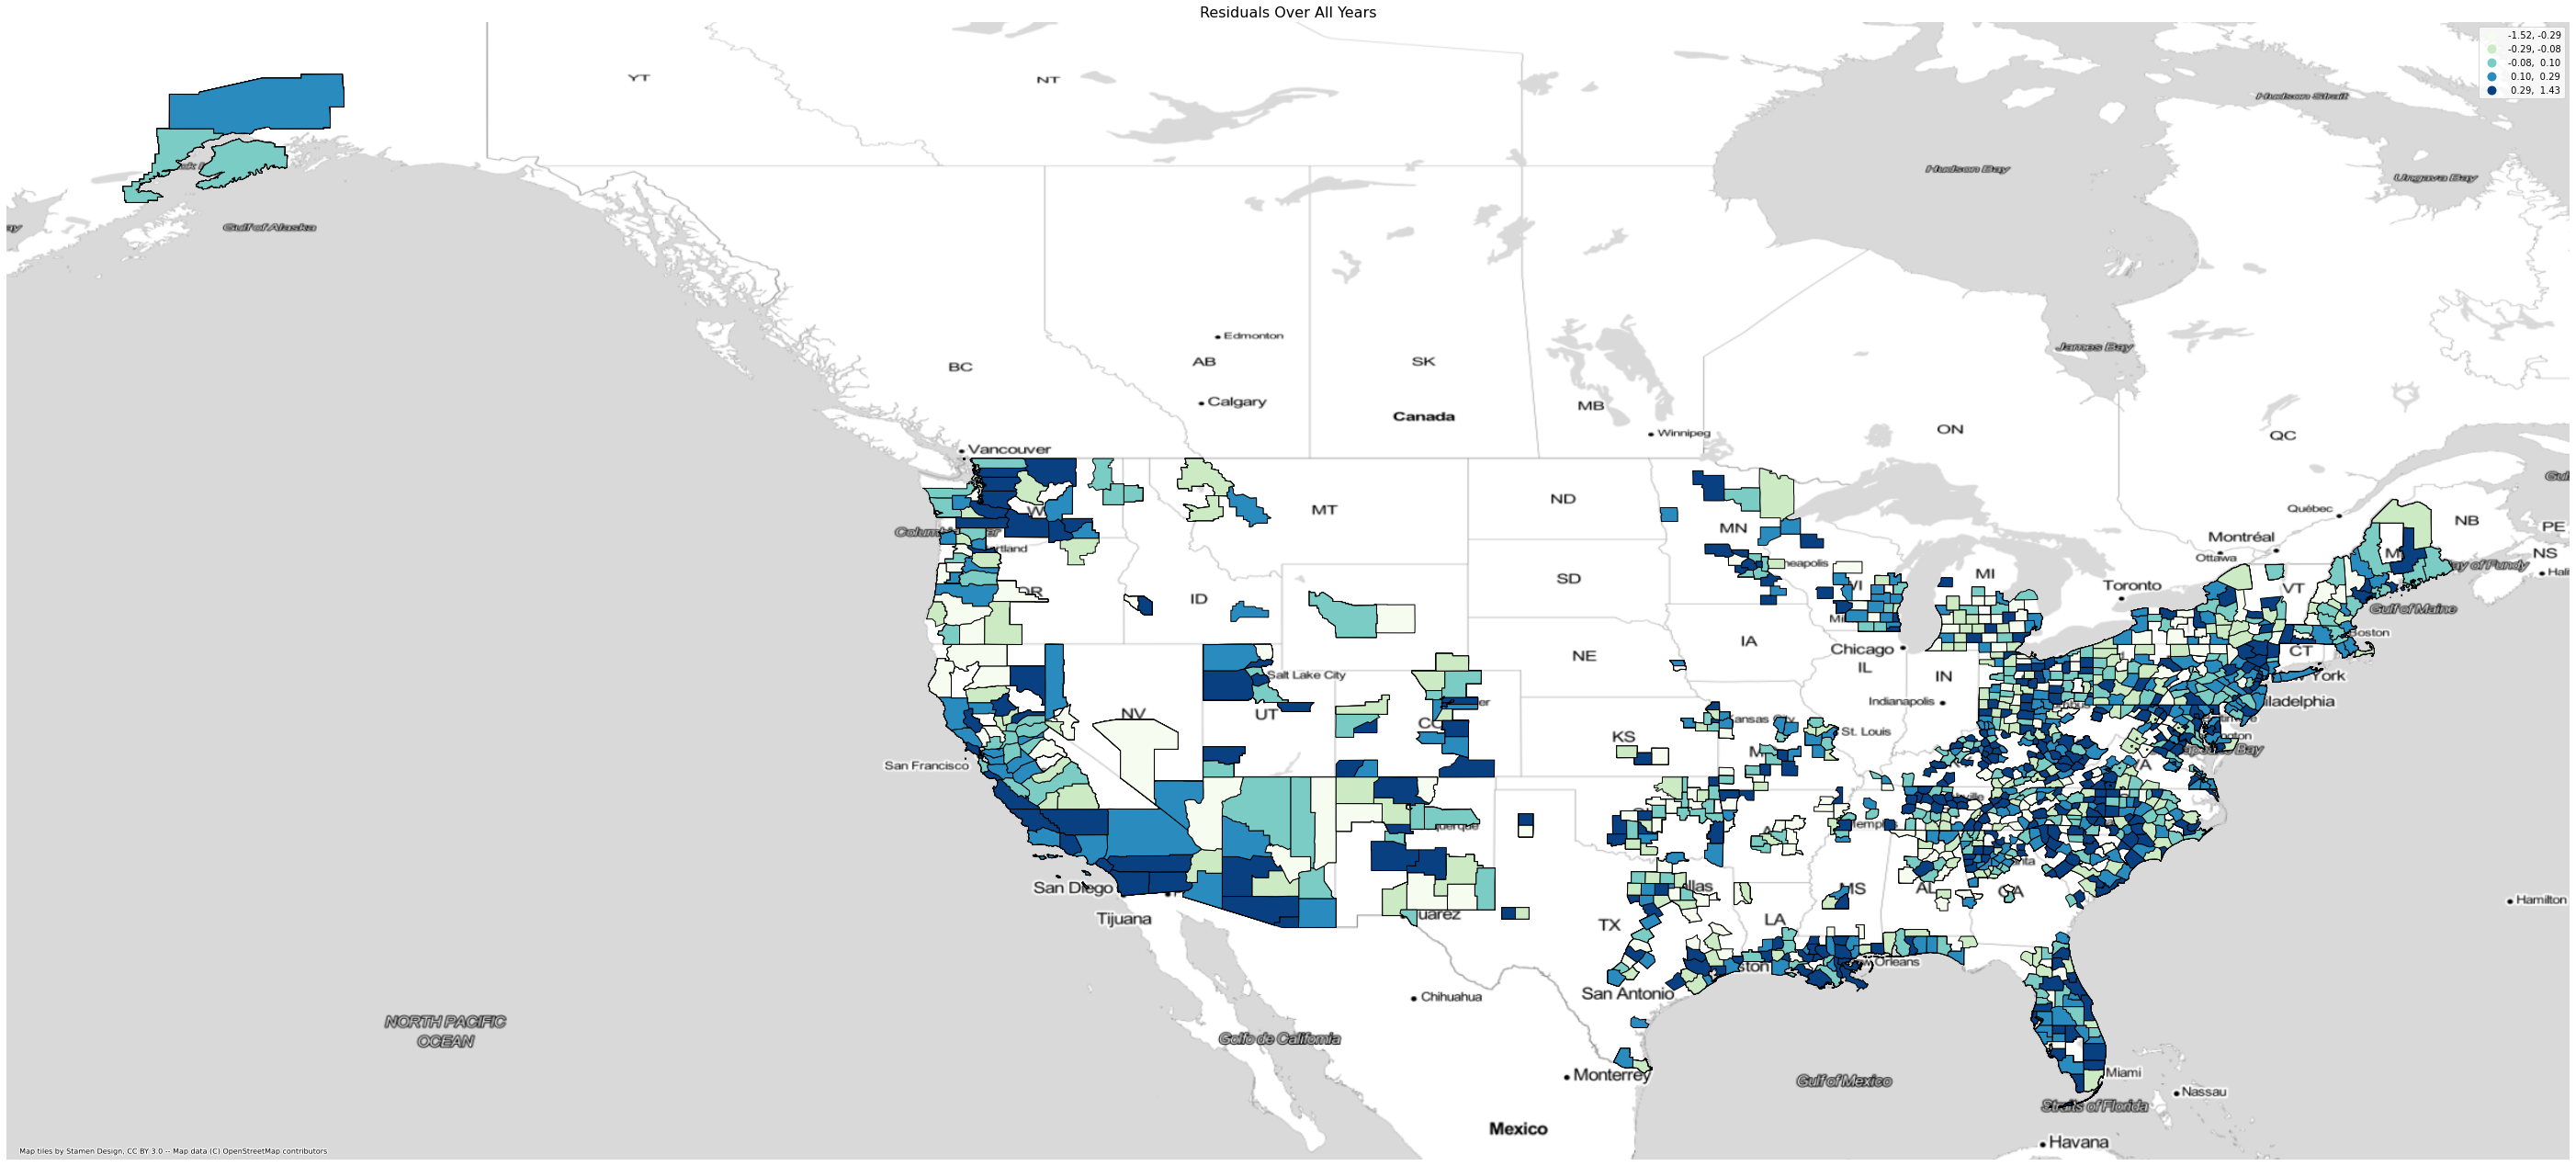

In [154]:
#now plot is on the map !!! 
#this will be across all of time 
f,ax = plt.subplots(1,1,figsize=(50,50))

geo_od_nonull.plot(column='Residuals', legend=True, ax=ax,
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')

ax.set_title("Residuals Over All Years", fontsize=16)

ax.axis('off')

cx.add_basemap(ax, crs=geo_od_nonull.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()


In [162]:
# Hard to tell whats going on with just the map so I am going to compute the Moran'a I for the residuals 
#Plot spatial weights:
from libpysal.weights.contiguity import Queen
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot, plot_moran
from splot.esda import plot_local_autocorrelation
import esda as esda


In [163]:
w = Queen.from_dataframe(geo_od_nonull)
geo_od_nonull_2 = geo_od_nonull.drop(w.islands)
w2 = Queen.from_dataframe(geo_od_nonull_2)

In [164]:
y = geo_od_nonull['Residuals']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.10291844557692428

As a rule of thumb we can see that Moran's I should be less than 0.3 in order for it to be considered something that is significant. 

### Compute the Moran's I for the predictors 

In [169]:
od

,log_Overdose_Rate_per_100k,Pct_Age_lt_18,log_Pct_Black,Potential_Years_Lost,Pct_Uninsured,log_PrimCarePhys_per_100k,Pct_Child_in_1ParentHH,Pct_Poverty,log_Spatial_Mean
0,2.553630,23.100000,2.397895,8321.800000,20.900000,4.794964,28.900000,13.4,3.075796
1,2.475265,23.400000,3.044522,11719.600000,15.600000,4.653008,38.200000,20.9,2.882247
2,2.519051,23.300000,0.993252,9564.700000,18.700000,4.347694,25.600000,18.2,3.538685
3,2.735118,25.500000,1.098612,9930.300000,21.100000,3.806662,29.200000,20.3,2.766661
4,3.737676,23.000000,3.499533,10843.400000,18.400000,4.347694,41.300000,25.5,2.573255
...,...,...,...,...,...,...,...,...,...
8013,3.123236,21.903856,0.808253,4820.302037,4.168638,4.003213,21.036707,5.1,3.373511
8014,3.173104,21.508564,0.951769,4812.293689,3.807879,4.931122,18.233691,4.2,3.355769
8015,3.097410,20.515144,1.153891,5939.367604,5.340179,4.386920,30.599278,8.7,2.996038
8016,3.211128,21.556362,0.631356,7032.122216,5.524299,4.995117,28.558645,9.4,2.334570


In [165]:
#Double checking the Moran's I value here for the predictor again 
y = geo_od_nonull['Overdose_Rate_per_100k']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.43608056384118865

In [ ]:
#This is the moran's I here 
y = geo_od_nonull['Residuals']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I